# Formatting Data (geometry)


In general, you need to format geometry when you get coordinates.

In [5]:
import pandas as pd
import os

where=os.path.join('DataFiles','calls911.pkl')
calls911=pd.read_pickle(where)
calls911.head()

,address,type,datetime,latitude,longitude,report_location,incident_number,date,year,month,weekday,hour,nightTime
0,4th Ave N / Mercer St,Triaged Incident,2022-08-18 10:15:00,47.624564,-122.348877,"{'type': 'Point', 'coordinates': [-122.348877,...",F220099503,2022-08-18,2022,August,Thursday,10,False
1,815 S Dearborn St,Investigate Out Of Service,2022-08-18 10:08:00,47.595831,-122.322292,"{'type': 'Point', 'coordinates': [-122.322292,...",F220099502,2022-08-18,2022,August,Thursday,10,False
2,9401 Myers Way S,Triaged Incident,2022-08-18 10:07:00,47.518658,-122.333265,"{'type': 'Point', 'coordinates': [-122.333265,...",F220099501,2022-08-18,2022,August,Thursday,10,False
3,11030 5th Ave Ne,Auto Fire Alarm,2022-08-18 09:11:00,47.709488,-122.323301,"{'type': 'Point', 'coordinates': [-122.323301,...",F220099179,2022-08-18,2022,August,Thursday,9,False
4,3013 Harvard Ave E,MVI - Motor Vehicle Incident,2022-08-18 09:06:00,47.647935,-122.322101,"{'type': 'Point', 'coordinates': [-122.322101,...",F220099178,2022-08-18,2022,August,Thursday,9,False


You know the call identify the location of the incident. Then you are interested in representing that coordinates in a map. You have this map:

In [6]:
import geopandas as gpd

theMapFile=os.path.join("DataFiles","Census_Tracts_2010.geojson")
seattleMap=gpd.read_file(theMapFile)
seattleMap.plot()

DriverError: DataFiles\Census_Tracts_2010.geojson: No such file or directory

The map came from a geojson file. It is a common format these days. However, the more familiar format has always been the shapefile (**.shp**)

All maps are a **projection** of our 3D world. So, maps, 2D objects, should let us know that:

In [7]:
# projection info is not here!!
seattleMap.info()

AttributeError: 'DataFrame' object has no attribute 'pkl'

In [ ]:
# it is here
seattleMap.crs

The **report_location** column came from the original data in the _API_; it has the coordinates of the event, and it is very useful. I can recover that in Python as it is a dictionary.

In [9]:
[x['coordinates'] for x in calls911.report_location[1:10]]

AttributeError: 'DataFrame' object has no attribute 'report_location'

Fortunately, we have already that information in the columns _longitude_ and _latitude_; so we can drop it:

In [8]:
calls911.drop(columns=["report_location"],inplace=True)

However, _longitude_ and _latitude_ are not numeric, then we need to format:

In [11]:
calls911[['longitude','latitude']]=calls911[['longitude','latitude']].apply(lambda x:pd.to_numeric(x))

Let's pay plot the coordinates:

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

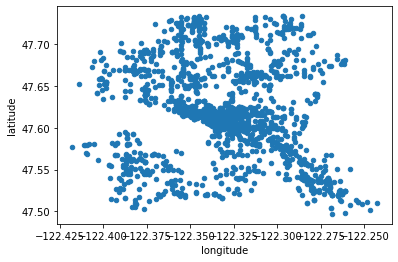

In [12]:
calls911.plot.scatter(x = 'longitude', y = 'latitude')

Now, let's plot the coordinates on top of the map:

<AxesSubplot:>

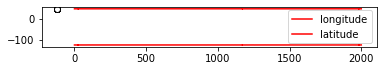

In [17]:
import matplotlib.pyplot as plt
ax = calls911_geo.plot(color='white',
                  edgecolor='black')

calls911[['longitude','latitude']].plot(ax=ax, color='red',markersize=0.5)

#plt.show()

It fails as it is not a spatial data frame.

The next step is to create a spatial dataframe for the 911 data. Let's use geopandas:

In [14]:
import geopandas as gpd

pointsAsGeometry=gpd.points_from_xy(calls911.longitude,
                                    calls911.latitude,crs="EPSG:4326")

calls911_geo = gpd.GeoDataFrame(calls911,
                                geometry=pointsAsGeometry)

# check:

calls911_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's redo the previous _failed_ plot:

<AxesSubplot:>

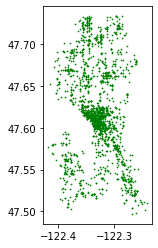

In [19]:
#ax = seattleMap.plot(color='white',
#                  edgecolor='black')

calls911_geo.plot(color='green',
                  markersize=0.5)
#plt.show()

Notice there is an event registered which is not in Seattle.

In [20]:
calls911_geo[calls911_geo.longitude==calls911_geo.longitude.max()]

,address,type,datetime,latitude,longitude,incident_number,date,year,month,weekday,hour,nightTime,geometry
989,7244 S Ryan St,Water Job Minor,2022-08-15 12:14:00,47.509647,-122.243003,F220097831,2022-08-15,2022,August,Monday,12,False,POINT (-122.24300 47.50965)


The map of Seattle has information of its limits: the **bounding box**. You can use that to filter the events:

In [23]:
calls911_geoclipped = gpd.clip(gdf=calls911_geo,
                               mask=seattleMap)

###clip mask - as marcações em potinhos para representar o mapa.

ax = seattleMap.plot(color='white',
                  edgecolor='black')

calls911_geoclipped.plot(ax=ax, color='red',
                  markersize=0.5)
plt.show()

NameError: name 'seattleMap' is not defined

We could save this file as an spatial data frame for further use in another program:

In [ ]:
# the datetime format can not be saved so we drop it.
# other choice could be to save it as a string.

whereGeo=os.path.join("DataFiles","calls911_geo.geojson")

calls911_geoclipped.drop(columns=["date"]).to_file(whereGeo,
                                            driver='GeoJSON')